In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# --- Cargar el archivo CSV en un DataFrame ---
df = pd.read_csv('./consumo_hogar.csv')

print("Primeras filas del dataset:")
print(df.head())

print("\nInformación general del DataFrame:")
df.info()

print("\nEstadísticos descriptivos:")
print(df.describe())


Primeras filas del dataset:
   Temperatura  Personas  Electrodomesticos  Consumo_kWh
0    17.031843       5.0               17.0    56.721828
1    16.682996       1.0                6.0    28.524528
2    18.809620       2.0               18.0    55.076458
3    27.307943       1.0                9.0    45.142576
4    21.212979       2.0               12.0    42.263797

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60373 entries, 0 to 60372
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperatura        57355 non-null  float64
 1   Personas           57355 non-null  float64
 2   Electrodomesticos  57355 non-null  float64
 3   Consumo_kWh        57355 non-null  float64
dtypes: float64(4)
memory usage: 1.8 MB

Estadísticos descriptivos:
        Temperatura      Personas  Electrodomesticos   Consumo_kWh
count  57355.000000  57355.000000       57355.000000  57355.000

Columnas del dataset: ['Temperatura', 'Personas', 'Electrodomesticos', 'Consumo_kWh']

Valores nulos por columna:
Temperatura          0
Personas             0
Electrodomesticos    0
Consumo_kWh          0
dtype: int64

Valores nulos después de eliminar filas incompletas:
Temperatura          0
Personas             0
Electrodomesticos    0
Consumo_kWh          0
dtype: int64


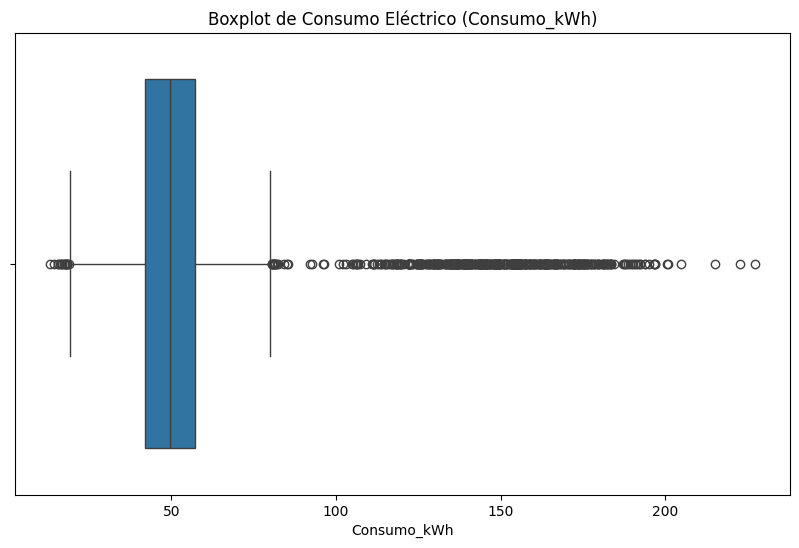


Tamaño original: (49184, 4), Tamaño sin outliers (IQR): (48661, 4)

Filas con posible outlier (Z-score > 3): 0


C:\Users\ivonn\AppData\Local\Temp\ipykernel_11388\2504735118.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['z_score'] = np.abs(
C:\Users\ivonn\AppData\Local\Temp\ipykernel_11388\2504735118.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=['z_score'], inplace=True)


In [6]:
# ==========================================================
# 2️⃣ LIMPIEZA DE DATOS  (versión corregida)
# ==========================================================

# --- Verificación de columnas disponibles ---
print("Columnas del dataset:", df.columns.tolist())

# --- Valores nulos ---
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Estrategia: eliminar filas con valores nulos (ya que suelen ser pocos)
df = df.dropna()
print("\nValores nulos después de eliminar filas incompletas:")
print(df.isnull().sum())

# --- Visualización de outliers ---
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Consumo_kWh'])
plt.title('Boxplot de Consumo Eléctrico (Consumo_kWh)')
plt.show()

# --- Detección de outliers: método IQR ---
Q1 = df['Consumo_kWh'].quantile(0.25)
Q3 = df['Consumo_kWh'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df_limpio = df[(df['Consumo_kWh'] >= lim_inf) & (df['Consumo_kWh'] <= lim_sup)]
print(f"\nTamaño original: {df.shape}, Tamaño sin outliers (IQR): {df_limpio.shape}")

# --- Detección alternativa con Z-score ---
df_limpio['z_score'] = np.abs(
    (df_limpio['Consumo_kWh'] - df_limpio['Consumo_kWh'].mean()) / df_limpio['Consumo_kWh'].std()
)
outliers_z = df_limpio[df_limpio['z_score'] > 3]
print(f"\nFilas con posible outlier (Z-score > 3): {outliers_z.shape[0]}")

# Eliminar la columna auxiliar
df_limpio.drop(columns=['z_score'], inplace=True)


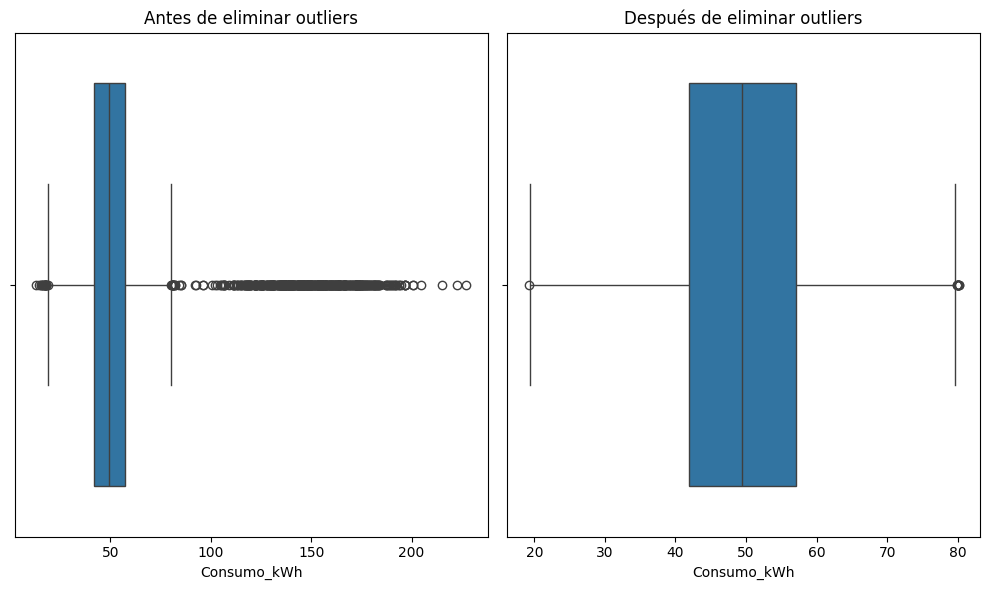

In [7]:
# ==========================================================
# 🔍 VALIDACIÓN VISUAL DE OUTLIERS
# ==========================================================

plt.figure(figsize=(10, 6))

# Boxplot antes de eliminar outliers
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Consumo_kWh'])
plt.title('Antes de eliminar outliers')

# Boxplot después de eliminar outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_limpio['Consumo_kWh'])
plt.title('Después de eliminar outliers')

plt.tight_layout()
plt.show()


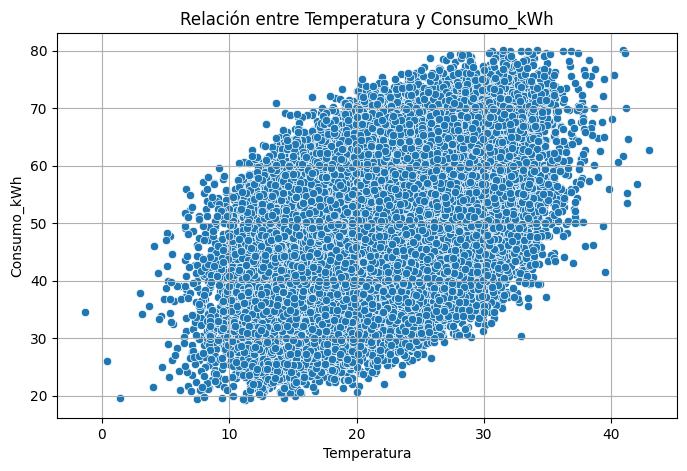

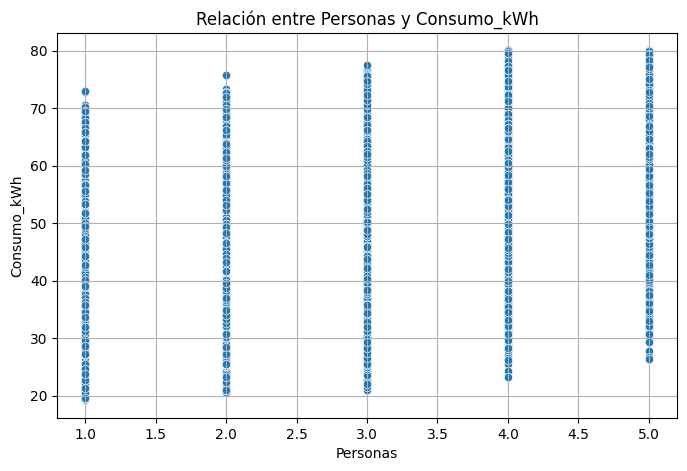

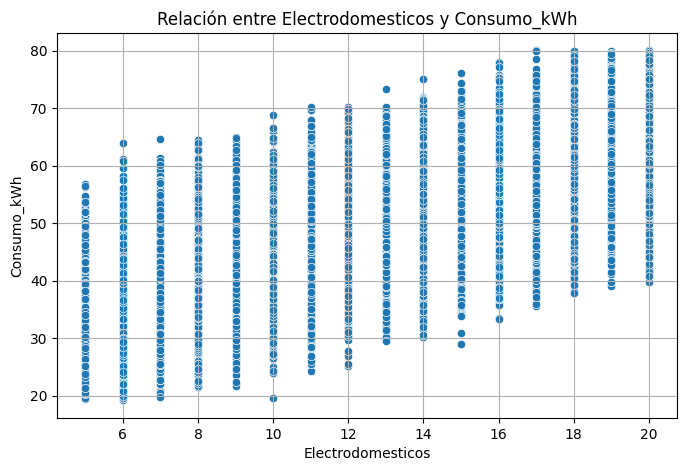

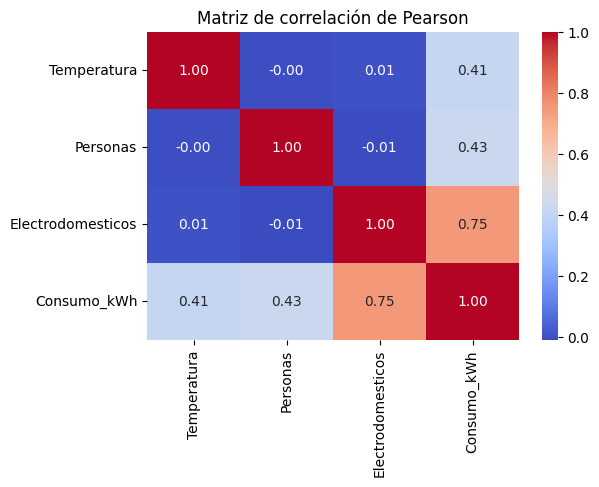


Correlaciones con Consumo_kWh:
Consumo_kWh          1.000000
Electrodomesticos    0.749769
Personas             0.428053
Temperatura          0.412746
Name: Consumo_kWh, dtype: float64


In [8]:
# ==========================================================
# 3️⃣ VISUALIZACIÓN EXPLORATORIA
# ==========================================================

features = ['Temperatura', 'Personas', 'Electrodomesticos']
target = 'Consumo_kWh'

# --- Gráficos de dispersión ---
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df_limpio[feature], y=df_limpio[target])
    plt.title(f'Relación entre {feature} y {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)
    plt.show()

# --- Matriz de correlación ---
plt.figure(figsize=(6, 4))
corr = df_limpio[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación de Pearson')
plt.show()

print("\nCorrelaciones con Consumo_kWh:")
print(corr['Consumo_kWh'].sort_values(ascending=False))

In [9]:
# ==========================================================
# 4️⃣ MODELADO: REGRESIÓN LINEAL Y POLINÓMICA
# ==========================================================

# --- División de datos ---
X = df_limpio[features]
y = df_limpio[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- a) Regresión Lineal Múltiple ---
print("\n--- REGRESIÓN LINEAL MÚLTIPLE ---")
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

print("Coeficientes:", modelo_lineal.coef_)
print("Intercepto:", modelo_lineal.intercept_)

# --- b) Regresión Polinómica (Grado 2 y 3) ---
print("\n--- REGRESIÓN POLINÓMICA GRADO 2 ---")
poly_2 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('linear_reg', LinearRegression())
])
poly_2.fit(X_train, y_train)

print("\n--- REGRESIÓN POLINÓMICA GRADO 3 ---")
poly_3 = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('linear_reg', LinearRegression())
])
poly_3.fit(X_train, y_train)



--- REGRESIÓN LINEAL MÚLTIPLE ---
Coeficientes: [0.8576546  3.19712084 1.70849659]
Intercepto: -0.2683016957177813

--- REGRESIÓN POLINÓMICA GRADO 2 ---

--- REGRESIÓN POLINÓMICA GRADO 3 ---


,steps,"[('poly_features', ...), ('linear_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06



--- RESULTADOS DE LOS MODELOS ---
                           Modelo       MSE  R² (Test)  R² (CV Promedio)
2  Regresión Polinómica (Grado 3)  9.002959   0.916762          0.916792
0                Regresión Lineal  9.004132   0.916751          0.916817
1  Regresión Polinómica (Grado 2)  9.004711   0.916746          0.916802


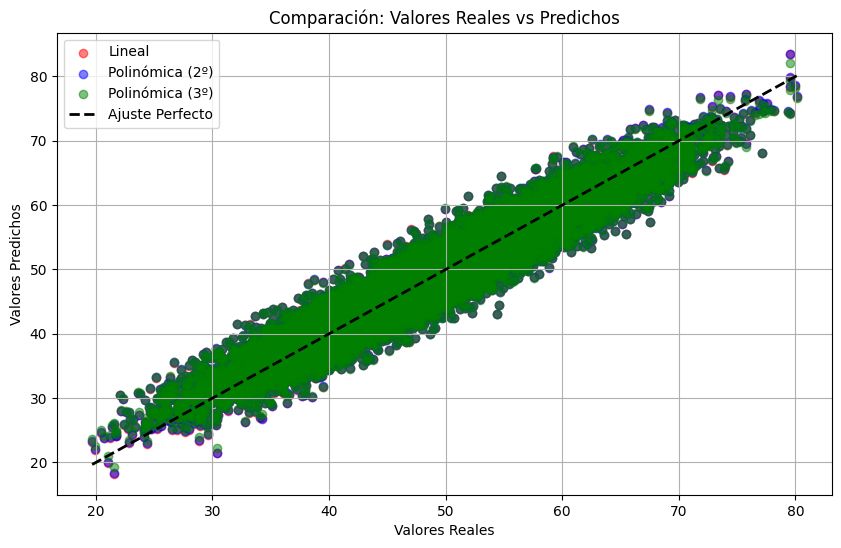


✅ El modelo con mejor desempeño según R² en test es: Regresión Polinómica (Grado 3)


In [11]:
# ==========================================================
# 5️⃣ EVALUACIÓN Y COMPARACIÓN DE MODELOS
# ==========================================================

# --- Predicciones ---
y_pred_lineal = modelo_lineal.predict(X_test)
y_pred_poly2 = poly_2.predict(X_test)
y_pred_poly3 = poly_3.predict(X_test)

# --- Cálculo de métricas ---
mse_lineal = mean_squared_error(y_test, y_pred_lineal)
r2_lineal = r2_score(y_test, y_pred_lineal)

mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
r2_poly2 = r2_score(y_test, y_pred_poly2)

mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
r2_poly3 = r2_score(y_test, y_pred_poly3)

# --- Validación cruzada (R² promedio) ---
cv_lineal = cross_val_score(modelo_lineal, X, y, cv=5, scoring='r2').mean()
cv_poly2 = cross_val_score(poly_2, X, y, cv=5, scoring='r2').mean()
cv_poly3 = cross_val_score(poly_3, X, y, cv=5, scoring='r2').mean()

# --- Resultados finales ---
df_resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Regresión Polinómica (Grado 2)', 'Regresión Polinómica (Grado 3)'],
    'MSE': [mse_lineal, mse_poly2, mse_poly3],
    'R² (Test)': [r2_lineal, r2_poly2, r2_poly3],
    'R² (CV Promedio)': [cv_lineal, cv_poly2, cv_poly3]
}).sort_values(by='R² (Test)', ascending=False)

print("\n--- RESULTADOS DE LOS MODELOS ---")
print(df_resultados)

# --- Gráfico de comparación real vs predicho ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lineal, alpha=0.5, label='Lineal', color='red')
plt.scatter(y_test, y_pred_poly2, alpha=0.5, label='Polinómica (2º)', color='blue')
plt.scatter(y_test, y_pred_poly3, alpha=0.5, label='Polinómica (3º)', color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2, label='Ajuste Perfecto')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación: Valores Reales vs Predichos')
plt.legend()
plt.grid(True)
plt.show()

# --- Conclusión automática ---
mejor_modelo = df_resultados.iloc[0]['Modelo']
print(f"\n✅ El modelo con mejor desempeño según R² en test es: {mejor_modelo}")

Columnas del dataset: ['Temperatura', 'Personas', 'Electrodomesticos', 'Consumo_kWh']
Tamaño del dataset: (60373, 4)


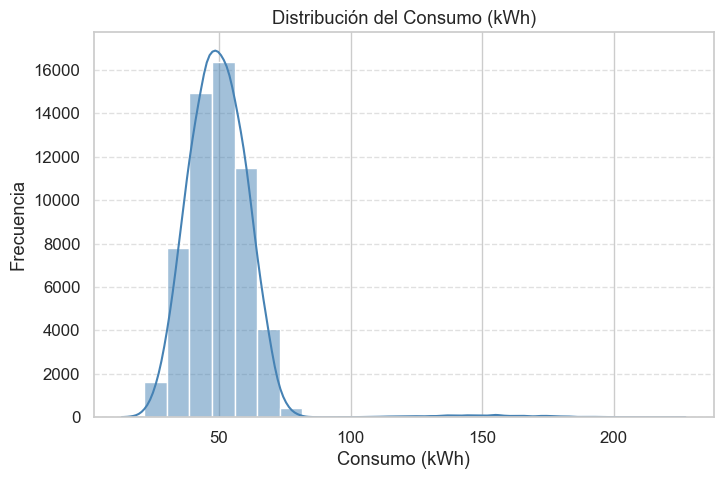

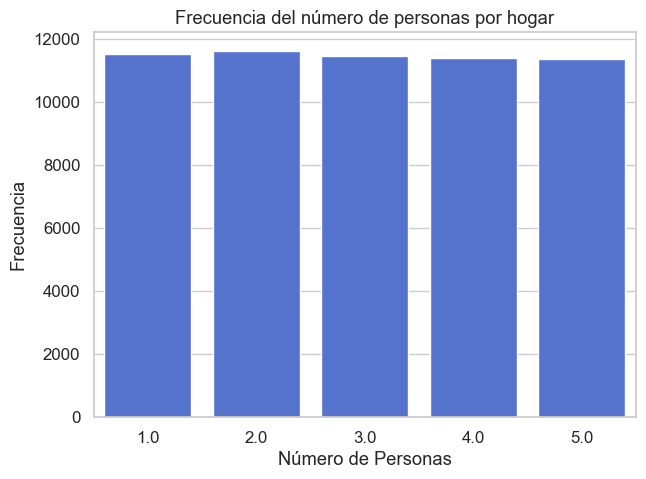

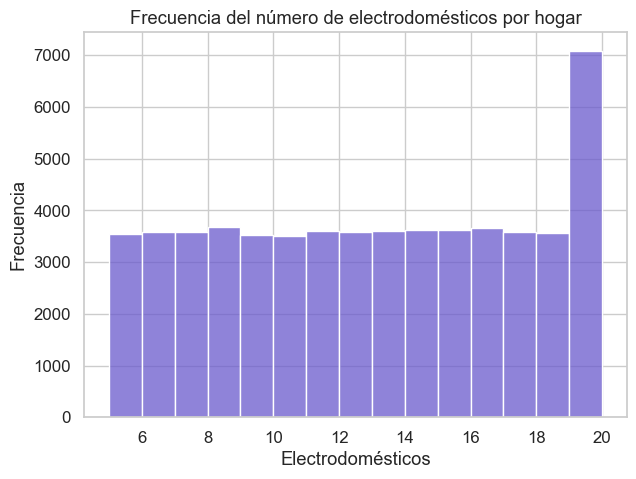

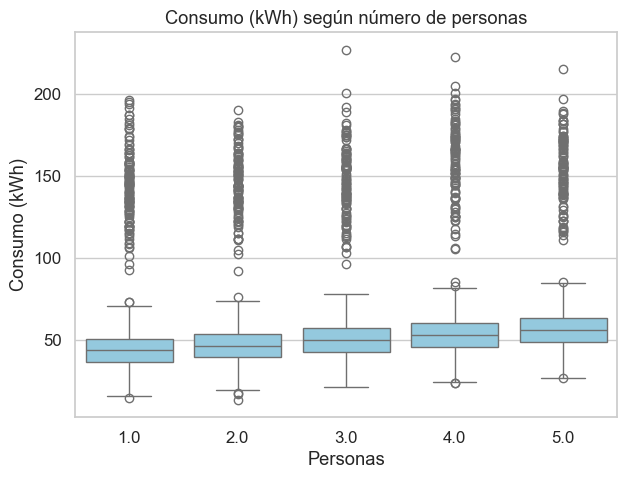

In [11]:
# ============================================================
# VISUALIZACIONES DEL ANÁLISIS EXPLORATORIO Y MODELADO PREDICTIVO
# ============================================================

# ==========================================
# Cargar dataset base
# ==========================================
import pandas as pd

# Cargar el CSV en un DataFrame
df = pd.read_csv('consumo_hogar.csv')

# Verificar estructura
print("Columnas del dataset:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)
df.head()


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Estilo general
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# ==========================================
# Figura 7. Distribución del consumo energético (Consumo_kWh)
# ==========================================
plt.figure(figsize=(8,5))
sns.histplot(df['Consumo_kWh'], bins=25, kde=True, color='steelblue')
plt.title('Distribución del Consumo (kWh)')
plt.xlabel('Consumo (kWh)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# ==========================================
# Figura 8. Frecuencia del número de personas por hogar
# ==========================================
plt.figure(figsize=(7,5))
sns.countplot(x='Personas', data=df, color='royalblue')
plt.title('Frecuencia del número de personas por hogar')
plt.xlabel('Número de Personas')
plt.ylabel('Frecuencia')
plt.show()


# ==========================================
# Figura 9. Frecuencia del número de electrodomésticos por hogar
# ==========================================
plt.figure(figsize=(7,5))
sns.histplot(df['Electrodomesticos'], bins=15, color='slateblue')
plt.title('Frecuencia del número de electrodomésticos por hogar')
plt.xlabel('Electrodomésticos')
plt.ylabel('Frecuencia')
plt.show()


# ==========================================
# Figura 10. Relación entre consumo energético y número de personas
# ==========================================
plt.figure(figsize=(7,5))
sns.boxplot(x='Personas', y='Consumo_kWh', data=df, color='skyblue')
plt.title('Consumo (kWh) según número de personas')
plt.xlabel('Personas')
plt.ylabel('Consumo (kWh)')
plt.show()



# 
